In [1]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
import scanpy as sc
import numpy as np
import pandas as pd
import random

In [2]:
TSP = sc.read_h5ad('DH_test.h5ad')
sc.pp.highly_variable_genes(TSP)
TSP = TSP[:, TSP.var.highly_variable]

In [3]:
# Assuming `adata` is your AnnData object
cellxgene_matrix = np.rint(TSP.X.todense()*10)
gene_names = TSP.var_names

# Convert the dense matrix to a DataFrame
df = pd.DataFrame(cellxgene_matrix, columns=gene_names)

# Function to convert each row (cell) to a document
def convert_to_documents(df):
    documents = []
    for _, row in df.iterrows():
        document = []
        for gene, count in row.items():
            if count > 0:
                document.extend([gene] * int(count))
        random.shuffle(document)  # Randomize the order of words
        documents.append(' '.join(document))
    return documents

In [4]:
documents = convert_to_documents(df)
#print(documents)

In [5]:
# Initialize BERTopic
topic_model = BERTopic(top_n_words = 150,
                   calculate_probabilities=True)

# Fit the model on the list of documents
topics, probs = topic_model.fit_transform(documents)

# Print topics
#print(topic_model.get_topic_info())

2024-06-05 17:26:02,457 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizer

In [6]:
log_perplexity = -1 * np.mean(np.log(np.sum(probs, axis=1)))
perplexity = np.exp(log_perplexity)
print(f"Perplexity: {perplexity}")

Perplexity: 1.7075848767110813


In [7]:
topic_info = topic_model.get_topic_info()
top_20_topics = topic_info.head(20)

# Display the top 20 topics
print(top_20_topics)

# Extract the top words (genes) for each of the top 10 topics
top_n = 20  # Number of top words to extract for each topic
top_words = {}

for topic_id in top_20_topics['Topic']:
    if topic_id == -1:
        continue  # Skip the outlier topic
    words = topic_model.get_topic(topic_id)[:top_n]
    top_words[topic_id] = [word[0] for word in words]

# Display the top words (genes) for each topic
for topic_id, words in top_words.items():
    print(f"Topic {topic_id}: {', '.join(words)}")

    Topic  Count                             Name  \
0      -1  21640        -1_nampt_dnajb1_psap_egr1   
1       0   2006          0_dock8_srgn_ptprc_cd69   
2       1   1362     1_pgam1_dnajb1_dazap2_hnrnpc   
3       2   1178       2_rock1_s100a9_s100a8_srgn   
4       3   1148     3_sparcl1_ifitm3_dnajb1_egr1   
5       4   1013    4_heatr5b_dazap2_nampt_dnajb1   
6       5    935      5_tuba1a_dnajb1_egr1_ifitm3   
7       6    878      6_sparcl1_psap_nampt_ifitm3   
8       7    827        7_cars1_cars2_psap_dnajb1   
9       8    788         8_cd69_srgn_ptprc_s100a9   
10      9    778     9_dnajb1_nampt_dazap2_atp2b4   
11     10    605      10_fancl_hladra_dnajb1_cd69   
12     11    597      11_sparcl1_a2m_notch1_epas1   
13     12    559       12_ighg1_iglc2_iglc3_ighg2   
14     13    422         13_pigs_psap_dnajb1_egr1   
15     14    387     14_gripap1_srgn_nampt_hladra   
16     15    351     15_coil_dazap2_ifitm3_dnajb1   
17     16    347        16_cd69_h4c3_dazap2_pt

In [8]:
# Capitalize all strings in the top_words dictionary
capitalized_top_words = {topic_id: [word.upper() for word in words] for topic_id, words in top_words.items()}

# Display the capitalized top words
for topic_id, words in capitalized_top_words.items():
    print(f"Topic {topic_id}: {', '.join(words)}")

Topic 0: DOCK8, SRGN, PTPRC, CD69, DOCK11, HLADRA, NAMPT, DAZAP2, SLC2A3, PSAP, TNFAIP3, DNAJB1, IL7R, RGS1, HNRNPC, SMCHD1, SMAP2, IFITM2, FYB1, MACF1
Topic 1: PGAM1, DNAJB1, DAZAP2, HNRNPC, PSAP, SLC38A2, IFITM3, NAMPT, EGR1, CLU, MT2A, SRGN, CD69, SPARCL1, SLC2A3, H4C3, PTPRC, TIMP1, EIF3E, RGS1
Topic 2: ROCK1, S100A9, S100A8, SRGN, NAMPT, PSAP, PTPRC, DAZAP2, IFITM2, THBS1, SLC2A3, HLADRA, HCLS1, SLC11A1, IL1R2, CD163, FCER1G, TNFAIP3, COTL1, JUND
Topic 3: SPARCL1, IFITM3, DNAJB1, EGR1, RNASE1, MGP, CXCL2, NAMPT, CFD, ADH1B, PSAP, CCL2, MT2A, A2M, CLU, SLC2A3, TIMP1, IFITM2, SLC38A2, TM4SF1
Topic 4: HEATR5B, DAZAP2, NAMPT, DNAJB1, HLADRA, CD69, SRGN, SLC2A3, PSAP, PTPRC, HNRNPC, IFITM3, SLC38A2, H4C3, EGR1, HEATR6, SPARCL1, HEATR1, MT2A, IFITM2
Topic 5: TUBA1A, DNAJB1, EGR1, IFITM3, SPARCL1, MGP, NAMPT, MT2A, SLC38A2, SLC2A3, PSAP, IFITM2, HNRNPC, CD69, DAZAP2, TIMP1, CCN1, CLU, ADH1B, LUM
Topic 6: SPARCL1, PSAP, NAMPT, IFITM3, TIMP1, MGP, EGR1, MT2A, IFITM2, SRGN, CLU, THBS1, DAZA

In [9]:
import gseapy as gp

In [10]:
go_analysis_results = {}

# Iterate through each cell type and their associated genes
for cell_type, genes in capitalized_top_words.items():
    # Run GO enrichment analysis
    enr = gp.enrichr(gene_list=genes,
                     gene_sets=['GO_Biological_Process_2021'],
                     organism='Human')

    # Store the results in the dictionary
    go_analysis_results[cell_type] = enr.results

# Convert results to DataFrame and save to a file if needed
all_results = []
for cell_type, result in go_analysis_results.items():
    result['cell_type'] = cell_type  # Add a column for the cell type
    all_results.append(result)

# Concatenate all results into a single DataFrame
all_results_df = pd.concat(all_results, ignore_index=True)

In [11]:
filtered_df = all_results_df[all_results_df['Adjusted P-value'] < 0.05]

filtered_df = filtered_df[filtered_df['Genes'].apply(lambda x: len(x.split(';'))>1)]

top_combined_score_df = filtered_df.loc[filtered_df.groupby('cell_type')['Combined Score'].idxmax()]


unique_term_df = top_combined_score_df.drop_duplicates(subset='Term', keep='first')

In [12]:
unique_term_df

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,cell_type
1,GO_Biological_Process_2021,B cell homeostasis (GO:0001782),2/10,4.254530e-05,0.007445,0,0,277.388889,2791.902845,DOCK11;TNFAIP3,0
351,GO_Biological_Process_2021,positive regulation of tau-protein kinase acti...,2/6,1.421569e-05,0.002765,0,0,554.888889,6193.205891,EGR1;CLU,1
745,GO_Biological_Process_2021,chronic inflammatory response (GO:0002544),2/5,9.482778e-06,0.000736,0,0,739.888889,8557.579527,S100A9;THBS1,2
1703,GO_Biological_Process_2021,negative regulation of viral entry into host c...,2/17,1.280437e-04,0.010000,0,0,147.888889,1325.548640,IFITM3;IFITM2,4
2974,GO_Biological_Process_2021,peptidyl-cysteine S-nitrosylation (GO:0018119),2/5,9.482778e-06,0.002880,0,0,739.888889,8557.579527,S100A9;S100A8,8
4123,GO_Biological_Process_2021,positive regulation of transcription of Notch ...,3/17,5.762613e-07,0.000235,0,0,251.672269,3615.701150,NOTCH3;NOTCH1;NOTCH4,11
4531,GO_Biological_Process_2021,B cell receptor signaling pathway (GO:0050853),2/34,5.228285e-04,0.021959,0,0,69.263889,523.375753,IGLL5;CD38,12
4886,GO_Biological_Process_2021,negative regulation of interleukin-2 productio...,2/22,2.168356e-04,0.044419,0,0,110.888889,935.499801,PTPRC;TNFAIP3,14
5609,GO_Biological_Process_2021,regulation of receptor signaling pathway via S...,2/13,7.361293e-05,0.022673,0,0,201.707071,1919.583635,PTPRC;IL7R,16
5918,GO_Biological_Process_2021,negative regulation of plasminogen activation ...,3/5,8.538975e-09,0.000002,0,0,1762.764706,32749.744097,SERPINE2;SERPINE1;THBS1,17


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
def score_cell_type_by_genes(adata, genes, cell_type):
    sub_adata = adata[adata.obs['cell_ontology_class'] == cell_type].copy()
    if len(genes) > 0 and sub_adata.n_obs > 0:
        sc.tl.score_genes(sub_adata, gene_list=genes, score_name='score')
        return sub_adata.obs['score'].mean()  # Average score of all cells of the type
    else:
        return np.nan

# Prepare the heatmap data matrix
heatmap_data = pd.DataFrame(index=unique_term_df['Term'], columns=TSP.obs['cell_ontology_class'].unique())

for idx, row in unique_term_df.iterrows():
    genes = row['Genes'].split(';')
    genes = [gene for gene in genes if gene in TSP.var_names]
    for cell_type in heatmap_data.columns:
        heatmap_data.at[row['Term'], cell_type] = score_cell_type_by_genes(TSP, genes, cell_type)

# Replace NaNs and convert to float for clustering
heatmap_data.fillna(0, inplace=True)
heatmap_data = heatmap_data.astype(float)

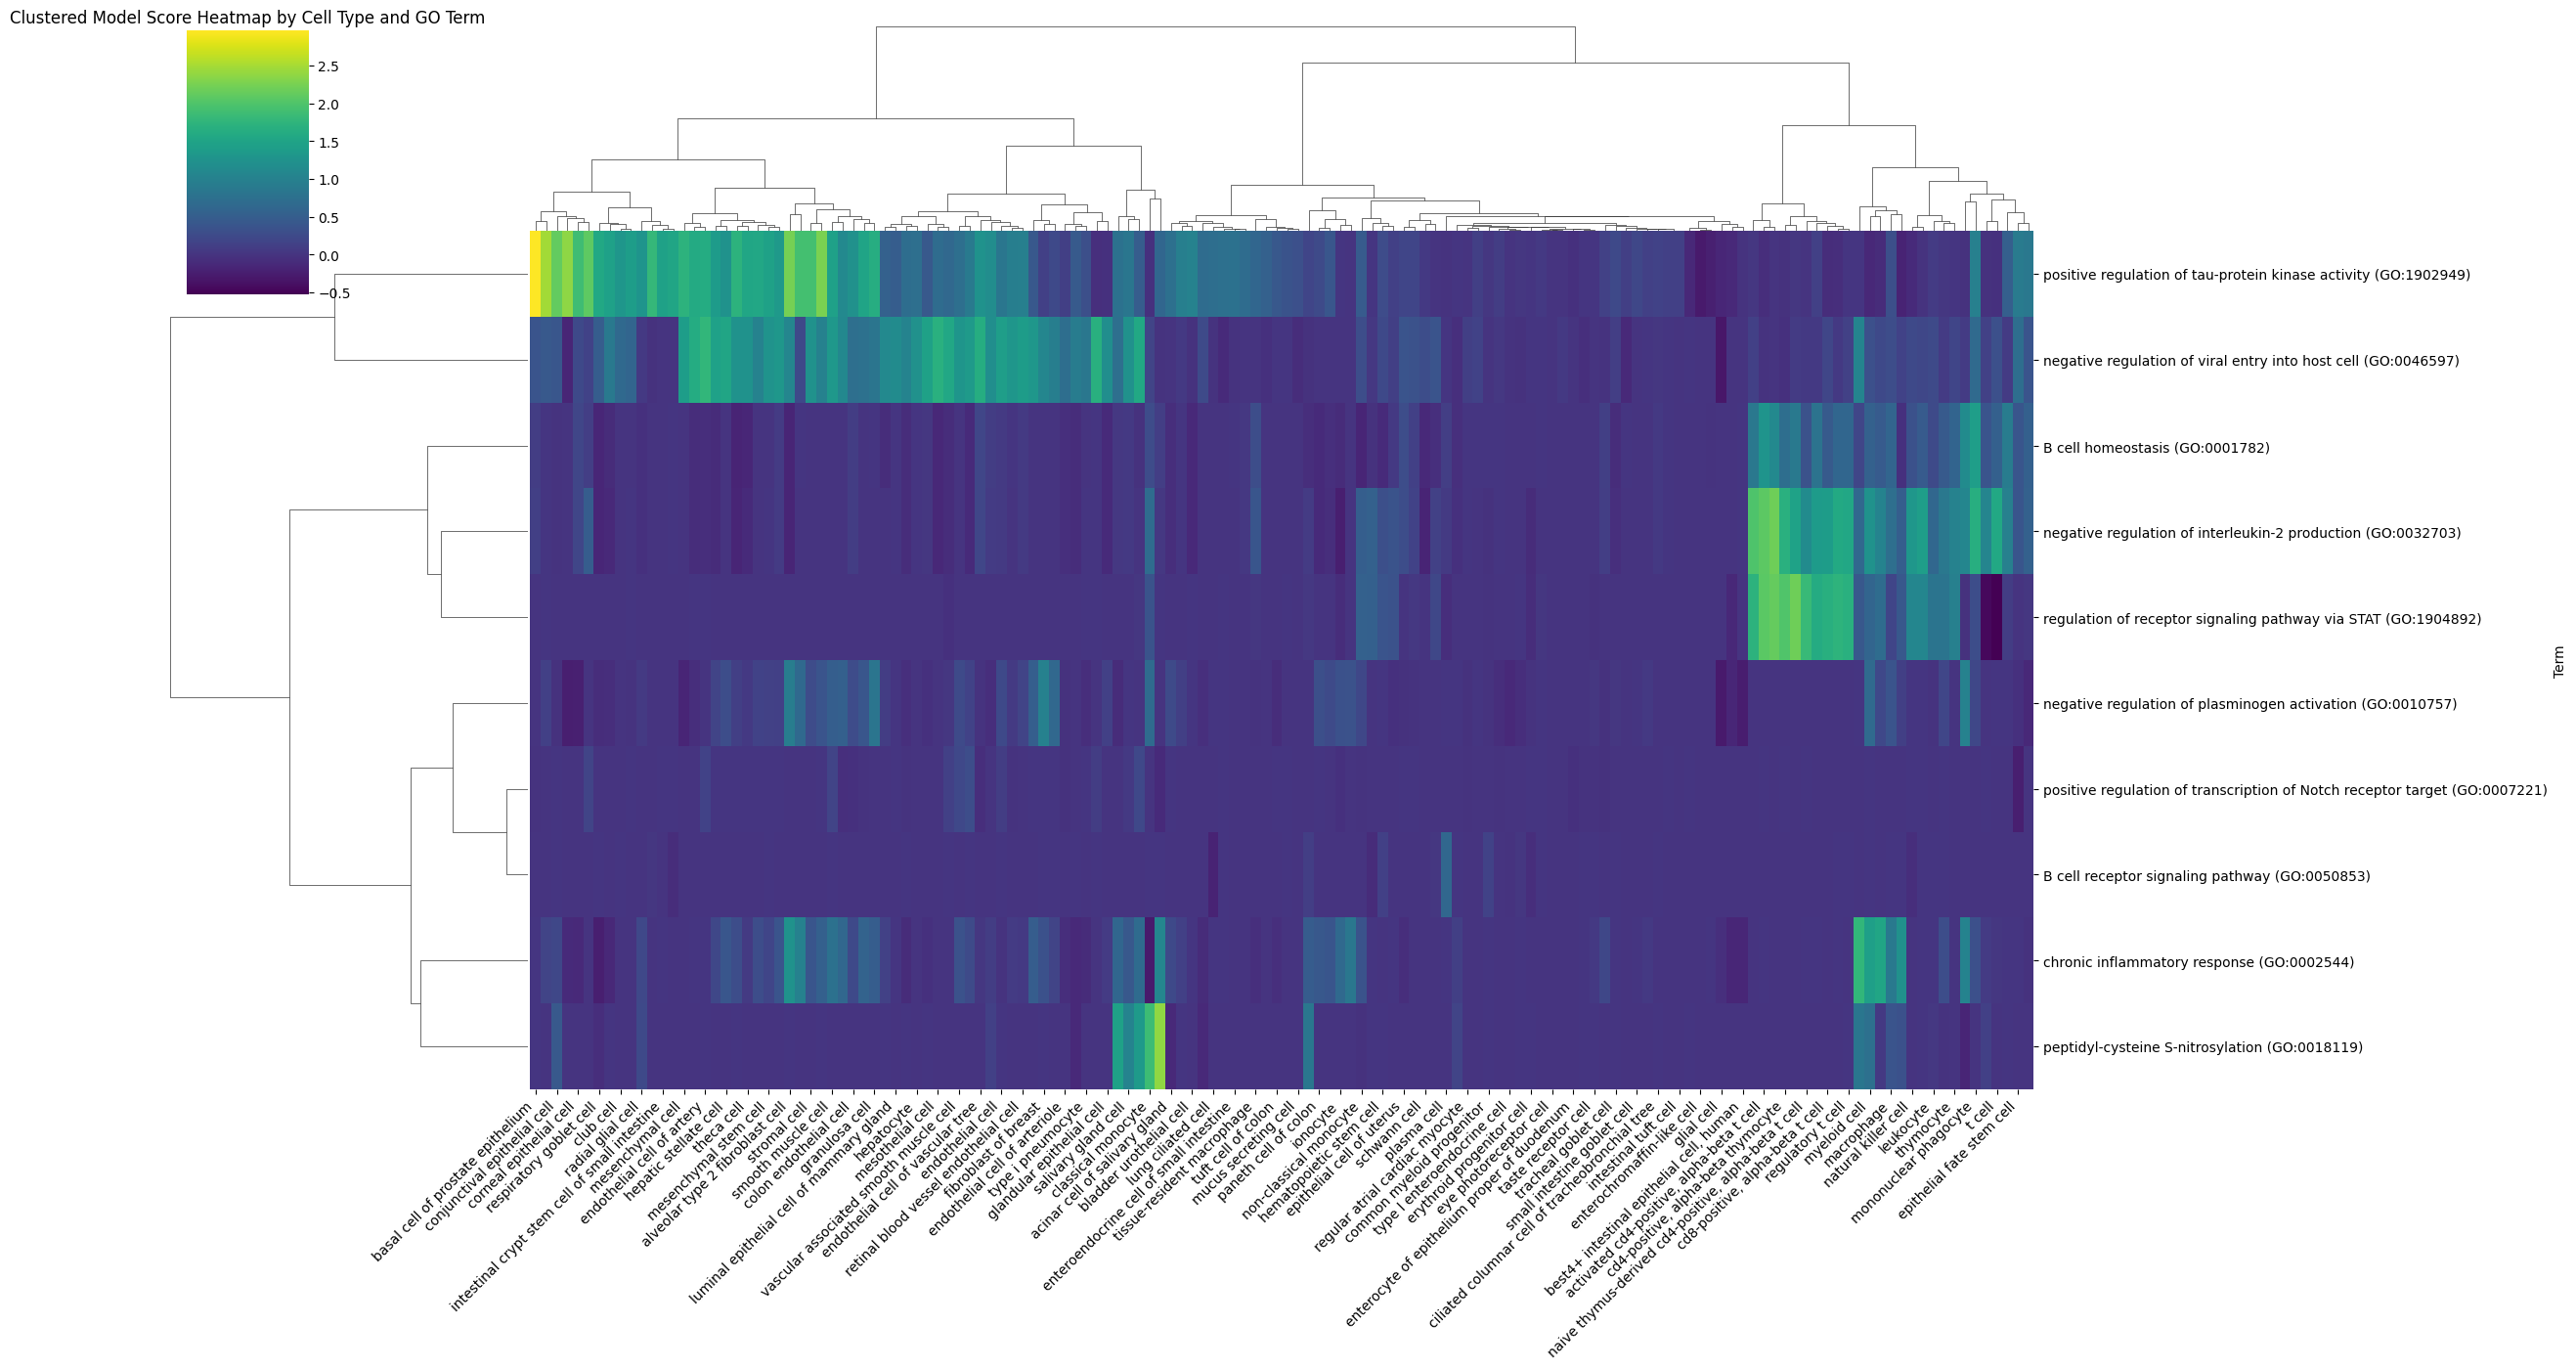

In [15]:
g = sns.clustermap(heatmap_data, method='ward', metric='euclidean', cmap='viridis', figsize=(25, 15), annot=False, fmt=".2f")
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')  # Rotate x labels for better visibility
plt.title('Clustered Model Score Heatmap by Cell Type and GO Term')
plt.show()

In [16]:
import os
import requests
url = "https://data.broadinstitute.org/gsea-msigdb/msigdb/release/7.5.1/c5.all.v7.5.1.symbols.gmt"

response = requests.get(url)
gmt_content = response.text

# Save the file
gmt_file_path = "h.all.v7.5.1.symbols.gmt"
with open(gmt_file_path, "w") as gmt_file:
    gmt_file.write(gmt_content)

# Function to parse the .gmt file
def parse_gmt(file_path):
    gene_sets = []
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split("\t")
            gene_set_name = parts[0]
            genes = parts[2:]
            gene_sets.append(genes)
    return gene_sets

# Parse the downloaded .gmt file
gene_sets = parse_gmt(gmt_file_path)

In [17]:
from collections import defaultdict

def build_cooccurrence_network(gene_sets):
    cooccurrence = defaultdict(set)
    for gene_set in gene_sets:
        for gene1 in gene_set:
            for gene2 in gene_set:
                if gene1 != gene2:
                    cooccurrence[gene1].add(gene2)
    return cooccurrence

cooccurrence_network = build_cooccurrence_network(gene_sets)

In [18]:
def get_top_genes(beta_matrix, feature_names, top_n=10):
    top_genes = []
    for topic_idx, topic in enumerate(beta_matrix):
        top_gene_indices = topic.argsort()[-top_n:][::-1]
        top_genes.append([feature_names[i] for i in top_gene_indices])
    return top_genes

In [19]:
topic_info = topic_model.get_topic_info()

# Create an empty DataFrame to hold the word scores
topic_gene_matrix = pd.DataFrame(0, index=range(len(topic_info) - 1), columns=gene_names)

# Populate the matrix with the word scores
for topic_id in topic_info['Topic']:
    if topic_id == -1:
        continue  # Skip the outlier topic
    words = topic_model.get_topic(topic_id)
    for word, score in words:
        if word in topic_gene_matrix.columns:
            topic_gene_matrix.at[topic_id, word] = score

In [20]:
# generate a beta matrix which is topicsxgenes and load in the gene names from our anndata
beta_matrix = topic_gene_matrix.iloc[:20].to_numpy()
feature_names = topic_gene_matrix.columns.tolist()
top_genes = get_top_genes(beta_matrix, feature_names)

In [21]:
from itertools import combinations

In [22]:
def calculate_gsea_coherence(top_genes, cooccurrence_network):
    coherence_scores = []
    for topic in top_genes:
        score = 0
        pairs_count = 0
        for gene1, gene2 in combinations(topic, 2):
            if gene2 in cooccurrence_network[gene1]:
                score += 1
            pairs_count += 1
        coherence_scores.append(score / pairs_count if pairs_count > 0 else 0)
    return np.mean(coherence_scores)

# Calculate coherence score based on MsigDB gene sets
gsea_coherence_score = calculate_gsea_coherence(top_genes, cooccurrence_network)
print("GSEA Coherence Score:", gsea_coherence_score)

GSEA Coherence Score: 0.28888888888888886


In [27]:
# Assuming TSP.var_names contains the gene names
genes = TSP.var_names

# Step 1: Generate 20 random modules, each containing 20 randomly selected genes
modules = []
for i in range(20):
    module = np.random.choice(genes, size=20, replace=False)
    modules.append(module)

# Step 2: Create a DataFrame with the modules as the indices and the genes as the columns
modules_names = [f'Module_{i+1}' for i in range(20)]
df = pd.DataFrame(0, index=modules_names, columns=genes)

# Step 3: Populate the DataFrame with 1s and 0s
for i, module in enumerate(modules):
    df.loc[modules_names[i], module] = 100

In [28]:
df.to_numpy()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [29]:
# generate a beta matrix which is topicsxgenes and load in the gene names from our anndata
beta_matrix = df.to_numpy()
feature_names = df.columns.tolist()
top_genes = get_top_genes(beta_matrix, feature_names)

In [30]:
gsea_coherence_score = calculate_gsea_coherence(top_genes, cooccurrence_network)
print("GSEA Coherence Score:", gsea_coherence_score)

GSEA Coherence Score: 0.1588888888888889
